> __Purpose:__ This NB tests a CNN in the agglomerative model clustering procedure. With later finetuning. Uses the previously developed PyTorch code

In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


from moments_engr import *
from agglo_model_clust import *
from DNN_FT_funcs import *

In [3]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)

print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

In [5]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [ ]:
def agglo_merge_procedure(userdef_df, model, mhp_knn_k=5, test_split_percent=0.3, n_splits=2):
    """
    Parameters:
    - model (str or sklearn model object): The model to train. If string, it must be one of:
      ['LogisticRegression', 'SVC', 'RF', 'GradientBoosting', 'KNN', 'XGBoost'].
    """
    
    # Select model
    if model_type == 'CNN':
        model = CNNModel(input_dim, num_classes).to('cpu')
    elif model_type == 'RNN':
        model = RNNModel(input_dim, num_classes).to('cpu')
        
    # Data structures for logging cluster merging procedure
    merge_log = []  # List of tuples: [(cluster1, cluster2, distance, new_cluster), ...]
    unique_clusters_log = []  # List of lists: [list of unique clusters at each step]
    # Dictionary to store self-performance over iterations
    intra_cluster_performance = {}
    cross_cluster_performance = {}
    # Simulate cluster merging and model performance tracking
    iterations = 0
    # Main loop for cluster merging
    while len(userdef_df['Cluster_ID'].unique()) > 1:
        print(f"{len(userdef_df['Cluster_ID'].unique())} Clusters Remaining")
        # Log the current state of clusters
        unique_clusters_log.append(sorted(userdef_df['Cluster_ID'].unique()))

        # userdef_df continuously changes wrt cluster ID
        ## So... do train_df and test_df continuously change? Cluster ID changes... 
        ## but that... may or may not affect stratificiation in a meaningful way (I'm not using cluster metadata...)
        train_df, test_df = split_train_test(userdef_df, test_size=test_split_percent, random_state=42)
        # These 2 should be the same... it's stratified...
        current_train_cluster_ids = sorted(train_df['Cluster_ID'].unique())
        current_test_cluster_ids = sorted(test_df['Cluster_ID'].unique())
        if current_train_cluster_ids == current_test_cluster_ids:
            current_cluster_ids = current_train_cluster_ids
        else:
            raise ValueError("Train/test Cluster ID lists not the same length... Stratify failed")

        # Train models with logging for specified clusters
        clus_model_lst = train_and_cv_cluster_model(train_df, model, current_cluster_ids, n_splits=n_splits)
        # Pairwise test models with logging for specified clusters
        sym_acc_arr = test_models_on_clusters(test_df, clus_model_lst, current_cluster_ids)

        for idx, cluster_id in enumerate(current_cluster_ids):
            cross_acc_sum = 0
            cross_acc_count = 0

            for idx2, cluster_id2 in enumerate(current_cluster_ids):
                if cluster_id not in intra_cluster_performance:
                    intra_cluster_performance[cluster_id] = []  # Initialize list

                if idx == idx2:  # Diagonal, so intra-cluster
                    # Ensure the logic assumption holds
                    if cluster_id != cluster_id2:
                        raise ValueError("This code isn't working as expected...")
                    intra_cluster_performance[cluster_id].append((iterations, sym_acc_arr[idx, idx2]))
                else:  # Non-diagonal, so cross-cluster
                    cross_acc_sum += sym_acc_arr[idx, idx2]
                    cross_acc_count += 1

            # Calculate average cross-cluster accuracy
            if cross_acc_count > 0:
                avg_cross_acc = cross_acc_sum / cross_acc_count
            else:
                avg_cross_acc = None  # Handle the case where no cross-cluster pairs exist
            # Append the average cross-cluster accuracy to all relevant clusters
            if cluster_id not in cross_cluster_performance:
                cross_cluster_performance[cluster_id] = []  # Initialize list
            cross_cluster_performance[cluster_id].append((iterations, avg_cross_acc))

        masked_diag_array = sym_acc_arr.copy()
        np.fill_diagonal(masked_diag_array, 0.0)
        similarity_score = np.max(masked_diag_array)
        max_index = np.unravel_index(np.argmax(masked_diag_array), masked_diag_array.shape)
        row_idx_to_merge = max_index[0]
        col_idx_to_merge = max_index[1]
        # Get actual cluster IDs to merge
        row_cluster_to_merge = current_cluster_ids[row_idx_to_merge]
        col_cluster_to_merge = current_cluster_ids[col_idx_to_merge]

        # Create a new cluster ID for the merged cluster
        new_cluster_id = max(current_cluster_ids) + 1
        #print(f"MERGE: {row_cluster_to_merge, col_cluster_to_merge} @ {similarity_score*100:.2f}. New cluster: {new_cluster_id}")
        # Log the merge
        merge_log.append((iterations, row_cluster_to_merge, col_cluster_to_merge, similarity_score, new_cluster_id))
        # Update the DataFrame with the new merged cluster
        userdef_df.loc[userdef_df['Cluster_ID'].isin([row_cluster_to_merge, col_cluster_to_merge]), 'Cluster_ID'] = new_cluster_id

        # Remove merged clusters from tracking (mark end with None)
        intra_cluster_performance[row_cluster_to_merge].append((iterations, None))
        intra_cluster_performance[col_cluster_to_merge].append((iterations, None))
        cross_cluster_performance[row_cluster_to_merge].append((iterations, None))
        cross_cluster_performance[col_cluster_to_merge].append((iterations, None))

        iterations += 1
    
    return merge_log, intra_cluster_performance, cross_cluster_performance

In [6]:
merge_log, intra_cluster_performance, cross_cluster_performance = agglo_merge_procedure(userdef_df, model_str)

32 Clusters Remaining
31 Clusters Remaining
30 Clusters Remaining
29 Clusters Remaining
28 Clusters Remaining
27 Clusters Remaining
26 Clusters Remaining
25 Clusters Remaining
24 Clusters Remaining
23 Clusters Remaining
22 Clusters Remaining
21 Clusters Remaining
20 Clusters Remaining
19 Clusters Remaining
18 Clusters Remaining
17 Clusters Remaining
16 Clusters Remaining
15 Clusters Remaining
14 Clusters Remaining
13 Clusters Remaining
12 Clusters Remaining
11 Clusters Remaining
10 Clusters Remaining
9 Clusters Remaining
8 Clusters Remaining
7 Clusters Remaining
6 Clusters Remaining
5 Clusters Remaining
4 Clusters Remaining
3 Clusters Remaining
2 Clusters Remaining


In [7]:
merge_log

[(0, 28, 19, 0.4482758620689655, 32),
 (1, 14, 0, 0.41935483870967744, 33),
 (2, 21, 11, 0.39285714285714285, 34),
 (3, 3, 31, 0.36, 35),
 (4, 32, 23, 0.35714285714285715, 36),
 (5, 2, 1, 0.35294117647058826, 37),
 (6, 26, 20, 0.3333333333333333, 38),
 (7, 4, 9, 0.3181818181818182, 39),
 (8, 36, 13, 0.3103448275862069, 40),
 (9, 6, 22, 0.3, 41),
 (10, 35, 18, 0.2857142857142857, 42),
 (11, 42, 5, 0.34375, 43),
 (12, 34, 25, 0.27586206896551724, 44),
 (13, 27, 29, 0.25806451612903225, 45),
 (14, 41, 38, 0.2545454545454545, 46),
 (15, 39, 45, 0.2537313432835821, 47),
 (16, 12, 8, 0.23333333333333334, 48),
 (17, 43, 37, 0.23076923076923078, 49),
 (18, 49, 33, 0.23529411764705882, 50),
 (19, 50, 44, 0.2391304347826087, 51),
 (20, 51, 17, 0.32142857142857145, 52),
 (21, 48, 46, 0.21052631578947367, 53),
 (22, 15, 7, 0.18518518518518517, 54),
 (23, 54, 24, 0.21428571428571427, 55),
 (24, 47, 40, 0.17647058823529413, 56),
 (25, 55, 52, 0.1553133514986376, 57),
 (26, 10, 56, 0.1392405063291139

## INTRA CLUSTER RESULTS

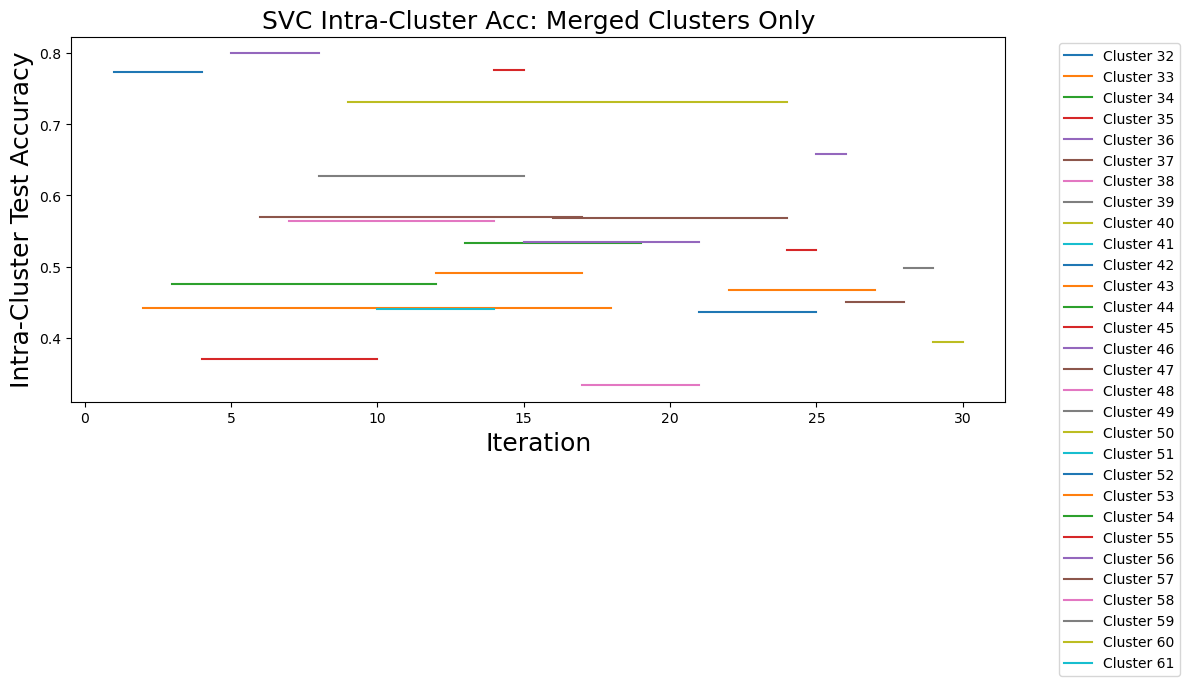

In [8]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc: Merged Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

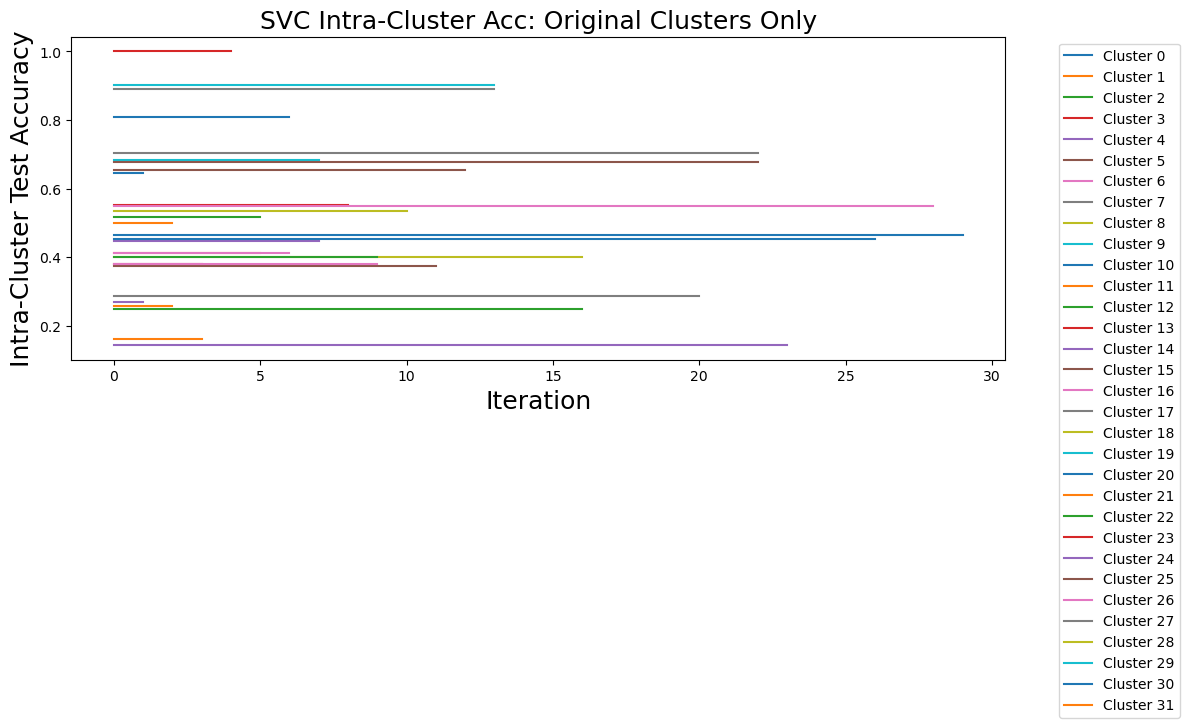

In [9]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc: Original Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## CROSS CLUSTER RESULTS

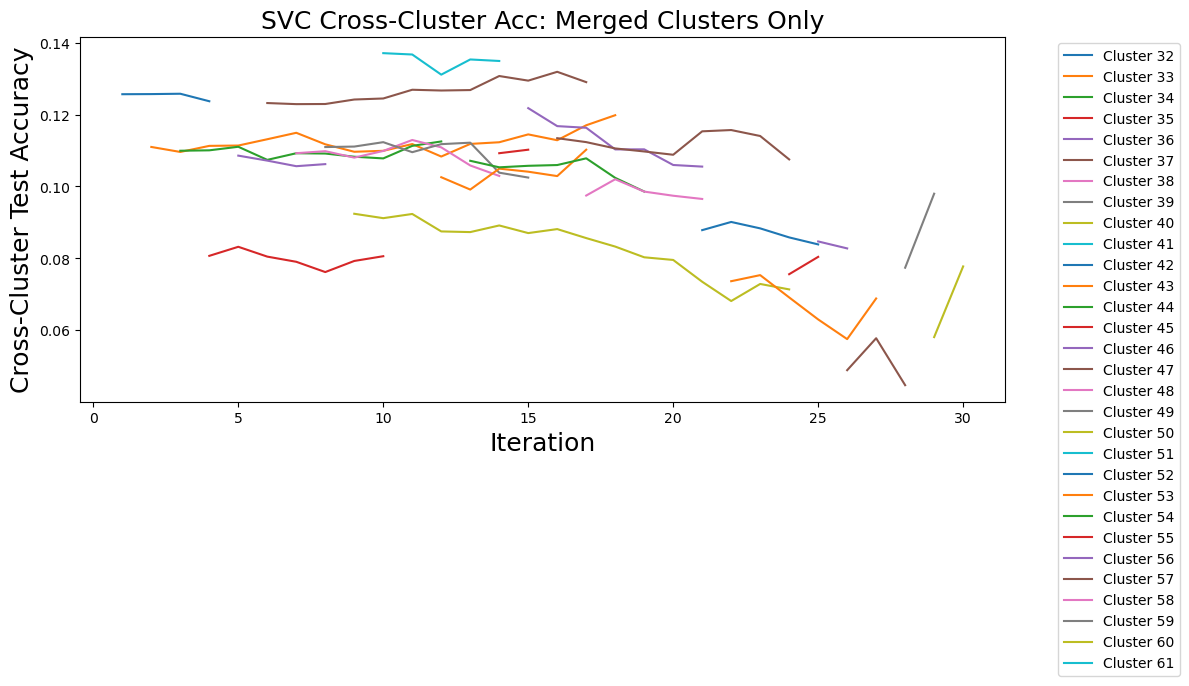

In [10]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc: Merged Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

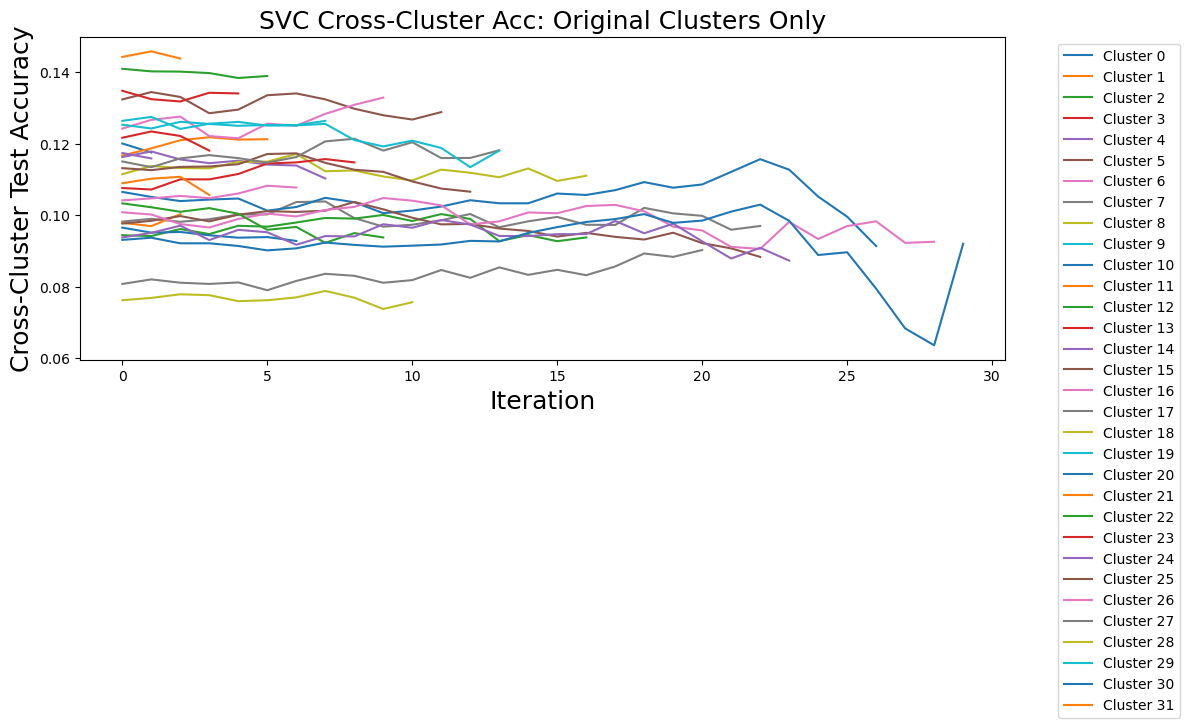

In [11]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc: Original Clusters Only", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

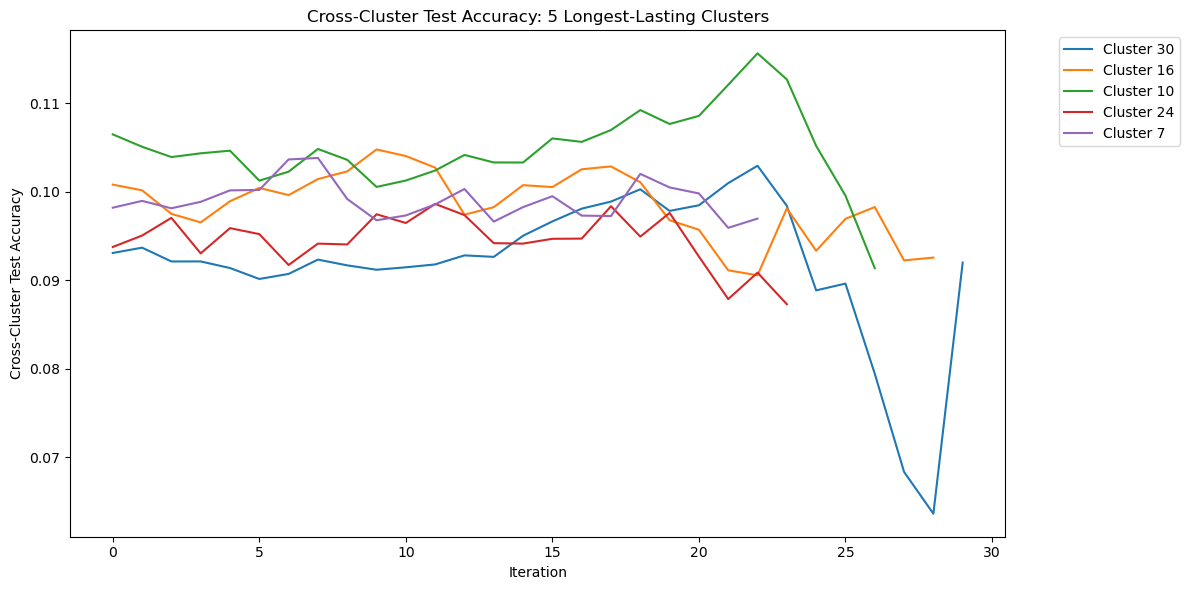

In [12]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5

# Reduce number of lines (e.g., top n longest-lived clusters)
longest_clusters = sorted(cross_cluster_performance.keys(), key=lambda k: len(cross_cluster_performance[k]), reverse=True)[:n]

for cluster_id in longest_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Longest-Lasting Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

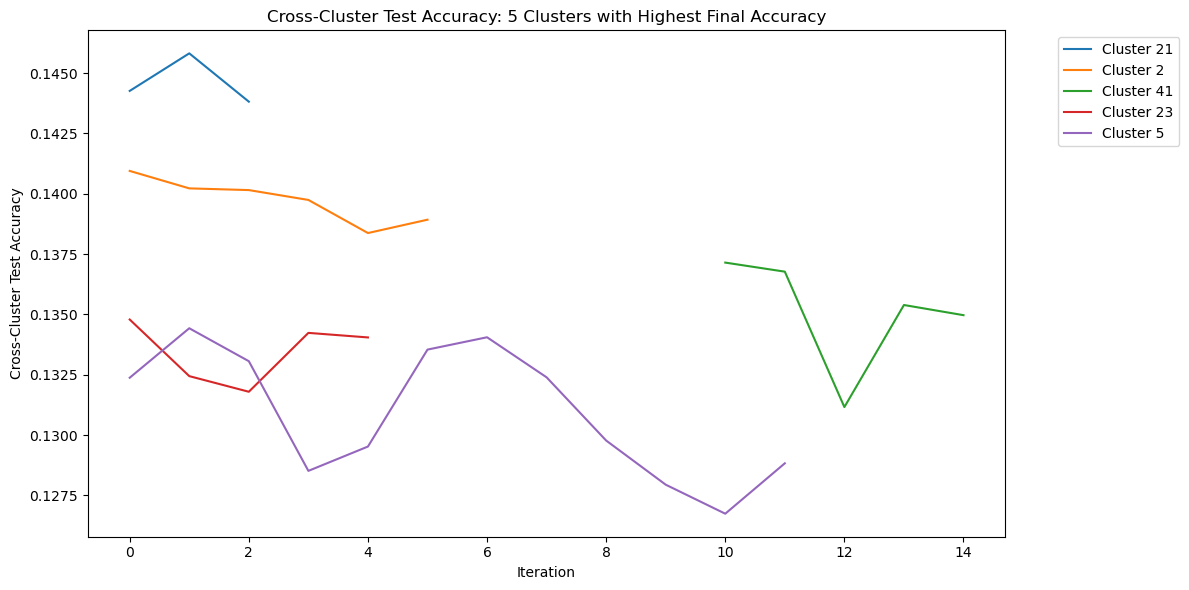

In [13]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5  # Number of clusters to plot

# Find clusters with the highest final accuracies
highest_final_accuracy_clusters = sorted(
    cross_cluster_performance.keys(), 
    key=lambda k: max([perf for it, perf in cross_cluster_performance[k] if perf is not None], default=0), 
    reverse=True
)[:n]

# Plot the performance curves for these clusters
for cluster_id in highest_final_accuracy_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Clusters with Highest Final Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Intra-Cluster Test Accuracy Merge Tracking

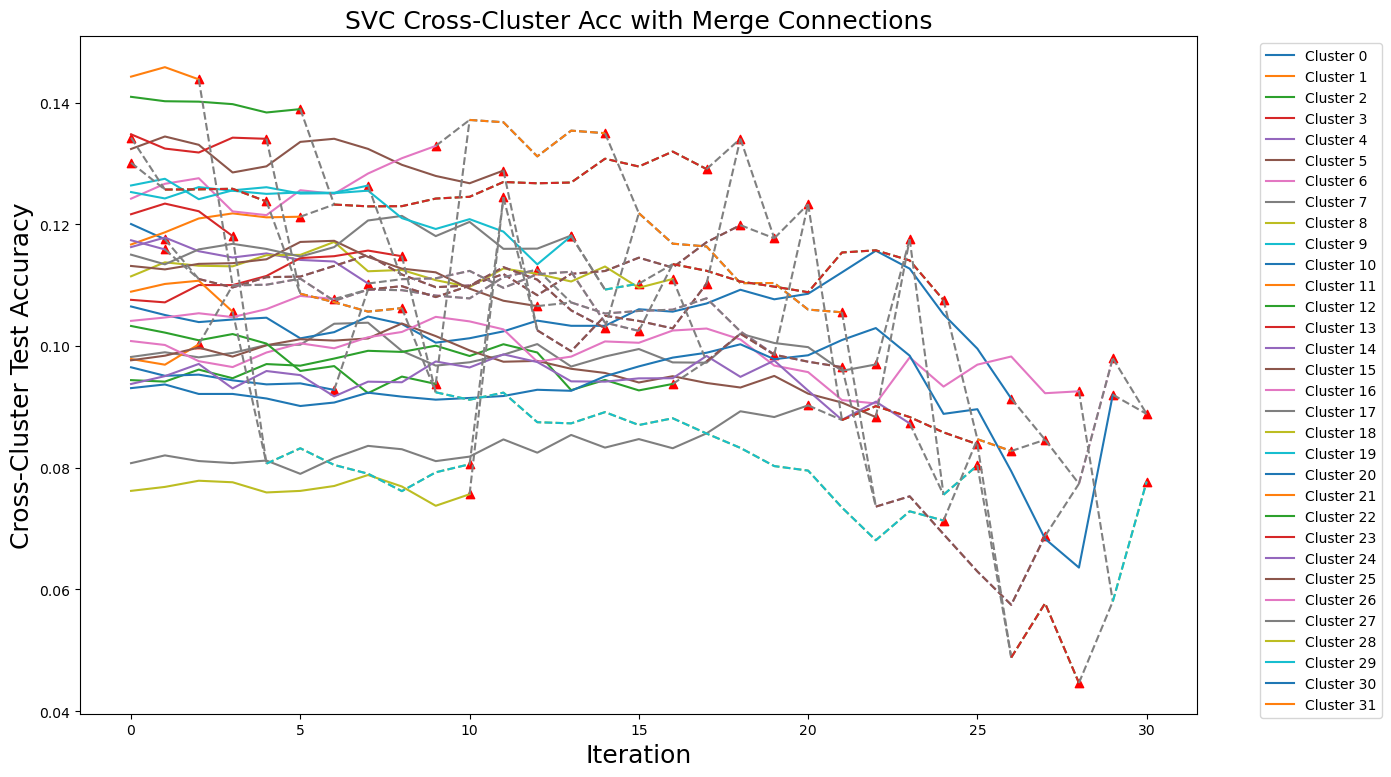

In [14]:
# Visualization with Merge Log and Connections
plt.figure(figsize=(14, 8))

# Dictionary to track the last valid point for each cluster
last_points = {}

# Plot original clusters
for cluster_id in cross_cluster_performance:
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0] != 0:
        continue

    # Plot original cluster performance
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")
    last_points[cluster_id] = (valid_iterations[-1], valid_performance[-1])  # Store the last point

# Handle merged clusters and connect original clusters
for iteration, cluster1, cluster2, _, new_cluster in merge_log:
    # Plot and connect the merged clusters
    for cluster in [cluster1, cluster2]:
        if cluster in cross_cluster_performance:
            data = cross_cluster_performance[cluster]
            merge_perf = next((perf for it, perf in data if it == iteration), None)
            if merge_perf is not None:
                plt.scatter(iteration, merge_perf, color='red', marker='^')#, label=f"Merge {cluster} → {new_cluster}")
                
        if cluster in last_points:  # If it's an original cluster
            last_iteration, last_perf = last_points[cluster]

            # Connect to the newly merged cluster
            if new_cluster in cross_cluster_performance:
                new_data = cross_cluster_performance[new_cluster]
                valid_iterations = [it for it, perf in new_data if perf is not None and it >= iteration]
                valid_performance = [perf for it, perf in new_data if perf is not None and it >= iteration]

                if valid_iterations:
                    # Draw a line connecting the original cluster to the new merged cluster
                    plt.plot(
                        [last_iteration, valid_iterations[0]],
                        [last_perf, valid_performance[0]],
                        linestyle='--', color='gray'
                    )

                    # Continue plotting the merged cluster's performance
                    plt.plot(valid_iterations, valid_performance, linestyle='--')

                # Update the last points for the newly merged cluster
                if valid_iterations:
                    last_points[new_cluster] = (valid_iterations[-1], valid_performance[-1])

# Add labels, legend, and formatting
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Cross-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Cross-Cluster Acc with Merge Connections", fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


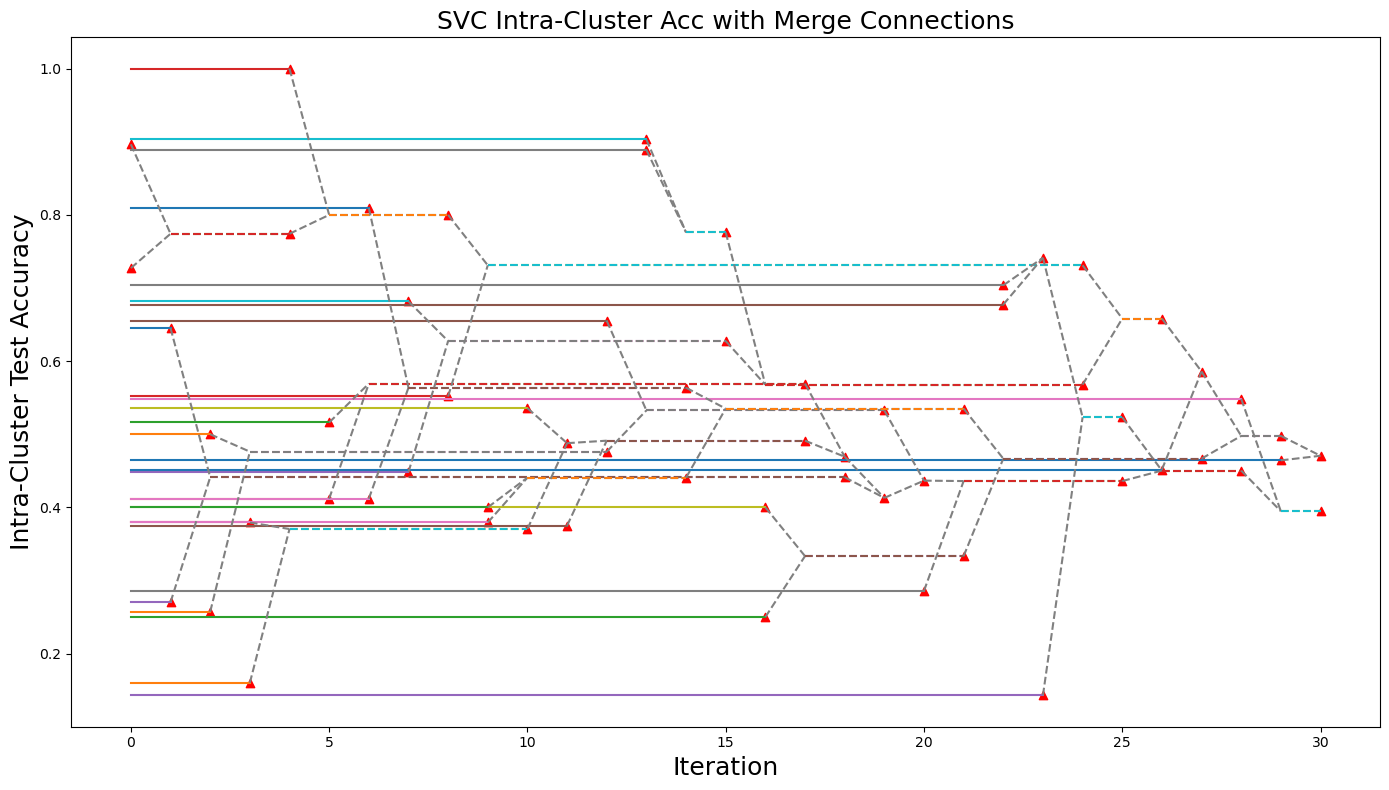

In [15]:
# Visualization with Merge Log and Connections
plt.figure(figsize=(14, 8))

# Dictionary to track the last valid point for each cluster
last_points = {}

# Plot original clusters
for cluster_id in intra_cluster_performance:
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0] != 0:
        continue

    # Plot original cluster performance
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")
    last_points[cluster_id] = (valid_iterations[-1], valid_performance[-1])  # Store the last point

# Handle merged clusters and connect original clusters
for iteration, cluster1, cluster2, _, new_cluster in merge_log:
    # Plot and connect the merged clusters
    for cluster in [cluster1, cluster2]:
        if cluster in intra_cluster_performance:
            data = intra_cluster_performance[cluster]
            merge_perf = next((perf for it, perf in data if it == iteration), None)
            if merge_perf is not None:
                plt.scatter(iteration, merge_perf, color='red', marker='^')#, label=f"Merge {cluster} → {new_cluster}")
                
        if cluster in last_points:  # If it's an original cluster
            last_iteration, last_perf = last_points[cluster]

            # Connect to the newly merged cluster
            if new_cluster in intra_cluster_performance:
                new_data = intra_cluster_performance[new_cluster]
                valid_iterations = [it for it, perf in new_data if perf is not None and it >= iteration]
                valid_performance = [perf for it, perf in new_data if perf is not None and it >= iteration]

                if valid_iterations:
                    # Draw a line connecting the original cluster to the new merged cluster
                    plt.plot(
                        [last_iteration, valid_iterations[0]],
                        [last_perf, valid_performance[0]],
                        linestyle='--', color='gray'
                    )

                    # Continue plotting the merged cluster's performance
                    plt.plot(valid_iterations, valid_performance, linestyle='--')

                # Update the last points for the newly merged cluster
                if valid_iterations:
                    last_points[new_cluster] = (valid_iterations[-1], valid_performance[-1])

# Add labels, legend, and formatting
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Intra-Cluster Test Accuracy", fontsize=18)
plt.title(f"{model_str} Intra-Cluster Acc with Merge Connections", fontsize=18)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [16]:
intra_mean_lst, cross_mean_lst, ratio_lst = compute_performance_ratios(intra_cluster_performance, cross_cluster_performance)



=== Performance Ratios ===
Cluster 0: Intra Mean = 0.645, Cross Mean = 0.119, Ratio = 5.431
Cluster 1: Intra Mean = 0.412, Cross Mean = 0.120, Ratio = 3.429
Cluster 2: Intra Mean = 0.516, Cross Mean = 0.140, Ratio = 3.694
Cluster 3: Intra Mean = 0.379, Cross Mean = 0.121, Ratio = 3.127
Cluster 4: Intra Mean = 0.448, Cross Mean = 0.115, Ratio = 3.908
Cluster 5: Intra Mean = 0.375, Cross Mean = 0.131, Ratio = 2.864
Cluster 6: Intra Mean = 0.379, Cross Mean = 0.126, Ratio = 2.999
Cluster 7: Intra Mean = 0.704, Cross Mean = 0.099, Ratio = 7.103
Cluster 8: Intra Mean = 0.400, Cross Mean = 0.113, Ratio = 3.555
Cluster 9: Intra Mean = 0.682, Cross Mean = 0.125, Ratio = 5.438
Cluster 10: Intra Mean = 0.452, Cross Mean = 0.105, Ratio = 4.305
Cluster 11: Intra Mean = 0.500, Cross Mean = 0.098, Ratio = 5.083
Cluster 12: Intra Mean = 0.250, Cross Mean = 0.097, Ratio = 2.590
Cluster 13: Intra Mean = 0.552, Cross Mean = 0.112, Ratio = 4.936
Cluster 14: Intra Mean = 0.270, Cross Mean = 0.117, Ratio 

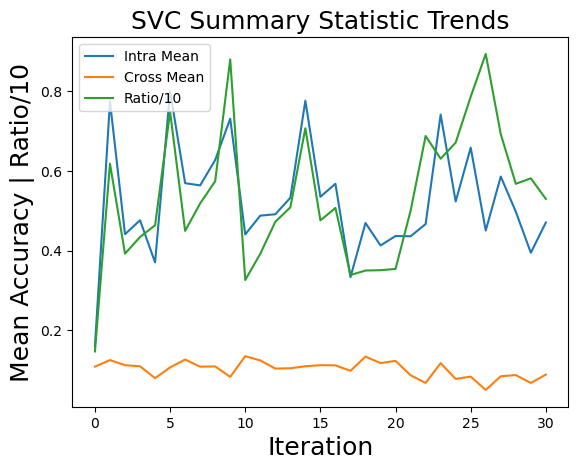

In [17]:
plt.plot(intra_mean_lst[31:], label="Intra Mean")
plt.plot(cross_mean_lst[31:], label="Cross Mean")
plt.plot((np.array(ratio_lst)/10)[31:], label="Ratio/10")
plt.xlabel("Iteration", fontsize=18)
plt.ylabel("Mean Accuracy | Ratio/10", fontsize=18)
plt.title(f"{model_str} Summary Statistic Trends", fontsize=18)
plt.legend(loc='upper left')